In [210]:
import torch
import pandas as pd
import numpy as np
import yaml
import importlib
import sys
import os
import matplotlib.pyplot as plt
import glob
from IPython.display import HTML, Markdown, display
from matplotlib.animation import FuncAnimation
import warnings
stf_dir = os.path.join(os.pardir, 'spacetimeformer')

sys.path.append(stf_dir)


import spacetimeformer as stf
importlib.reload(stf) #to make sure the last version of stf is used

from torch.distributions import Normal
import pickle

In [59]:
#load the dataset 

#important note: the dataset must be the same as the one used to train the lstm
data_path = "../Datasets/Forecasting_Aqua/data_h_log_cst_int_clusters_v5.csv"
format = "%Y-%m-%d %H:%M:%S"
df = pd.read_csv(data_path)


In [190]:
def format_config(run_dir):
    with open(run_dir) as file:
        # The FullLoader parameter handles the conversion from YAML
        # scalar values to Python the dictionary format
        config = yaml.load(file, Loader=yaml.FullLoader)
    config_pross = {}
    for key in config:
        try:
            config_pross[key]=config[key]['value']
        except:
            config_pross[key]=config[key]
    return config_pross
def find_fold(run_dirs,fold):
    config_0 = None
    for run_dir in run_dirs:
        config = format_config(run_dir)
        if config_0 is not None:
            for key in config.keys():
                if key!= 'fold_val' and key != '' and key != '_wandb':
                    assert config[key]==config_0[key], f"key {key} is different: {config[key]} {config_0[key]}"
                elif key == 'fold_val':
                    if config_pross['fold_val']==fold:
                        run_dir_fold = run_dir
                        config_fold = config
        if config_0 is None:
            config_0=config
    return config_fold

#load an lstm trained by k-fold:
def build_lstm_from_old_runs(run_dirs,fold):

    config = find_fold(run_dirs,fold)
    
    if config['dset']=='log_cluster_HF_int5':
        date_format = "%Y-%m-%d %H:%M"
        data_path_config = "../Datasets/Forecasting_Aqua/data_h_log_cst_int_clusters_v5.csv"
        df = pd.read_csv(data_path_config)
        target_cols = ['mean_chla_depth']
        target_cols+=list(df.keys().drop(['Datetime','mean_chla_depth']))
        NULL_VAL = 0.  
    assert data_path == data_path_config
    dset = stf.data.CSVTimeSeriesV2(
        data_path=data_path,
        target_cols=target_cols,
        date_format = date_format,
        nanval = NULL_VAL,
        folds = config['folds'],
        fold_n = config['fold_val'],
    )

    x_dim = 4 if 'HF' in config['dset'] else 3
    y_dim = len(target_cols)
    if config['model'] == "lstm":
        forecaster = stf.lstm_model.LSTM_Forecaster(
            # encoder
            d_x=x_dim,
            d_y=y_dim,
            time_emb_dim=config['time_emb_dim'],
            hidden_dim=config['hidden_dim'],
            n_layers=config['n_layers'],
            dropout_p=config['dropout_p'],
            # training
            learning_rate=config['learning_rate'],
            teacher_forcing_prob=config['teacher_forcing_start'],
            l2_coeff=config['l2_coeff'],
            loss=config['loss'],
            linear_window=config['linear_window'],
        )
    else:
        print(f"{config['model']} model not implemented")
        

    return forecaster,target_cols
'''
run_names=[
 'run-20220501_164423-1jg8sfd2',
 'run-20220501_170145-3pxb1e2e',
 'run-20220501_182745-t886lin7',
 'run-20220501_184139-2h9lsz9j',
 'run-20220501_190719-1ntzk92u',
 'run-20220501_192103-3ft1ne4h',
 'run-20220501_233443-3i5bxssg',
 'run-20220501_234535-2z0whq99',
 'run-20220501_235550-1nevxs23',
 'run-20220502_000508-2l2k5p7k']
run_dirs = ["..\\spacetimeformer\\spacetimeformer\\data\\stf_LOG_DIR\\wandb\\" + run_name+"\\files\\config.yaml" 
           for run_name in run_names]'''
build_lstm_from_old_runs(run_dirs,0)

(LSTM_Forecaster(
   (linear_model): LinearModel(
     (linear): Linear(in_features=1, out_features=1, bias=True)
   )
   (t2v): Time2Vec()
   (encoder): LSTM_Encoder(
     (lstm): LSTM(37, 64, num_layers=2, batch_first=True, dropout=0.3)
   )
   (decoder): LSTM_Decoder(
     (lstm): LSTM(37, 64, num_layers=2, batch_first=True, dropout=0.3)
     (fc): Linear(in_features=64, out_features=25, bias=True)
   )
   (model): LSTM_Seq2Seq(
     (t2v): Time2Vec()
     (encoder): LSTM_Encoder(
       (lstm): LSTM(37, 64, num_layers=2, batch_first=True, dropout=0.3)
     )
     (decoder): LSTM_Decoder(
       (lstm): LSTM(37, 64, num_layers=2, batch_first=True, dropout=0.3)
       (fc): Linear(in_features=64, out_features=25, bias=True)
     )
   )
 ),
 ['mean_chla_depth',
  'aphanizomenon',
  'cluster_1',
  'cluster_2',
  'cluster_3',
  'cluster_4',
  'cluster_5',
  'cluster_6',
  'cluster_7',
  'cluster_8',
  'mean_temp_depth',
  'mean_o2_depth',
  'mean_ph_depth',
  'precipitation_tot',
  'win

In [538]:
def generate_batch(list_of_tuple, batch_size):
    if batch_size<=0:
        return
    for i in range(0, len(list_of_tuple), batch_size):
        yield (torch.cat([el[0].unsqueeze(0) for el in list_of_tuple[i : i + batch_size]]),
               torch.cat([el[1].unsqueeze(0) for el in list_of_tuple[i : i + batch_size]]),
               torch.cat([el[2].unsqueeze(0) for el in list_of_tuple[i : i + batch_size]]),
               torch.cat([el[3].unsqueeze(0) for el in list_of_tuple[i : i + batch_size]]),
              )
#build the same kind of wrapper than for the baselines:
class lstm_loader:
    def __init__(self,target_keys:list, run_dirs,allow_neg = True):
        from sklearn.preprocessing import StandardScaler
        self._scaler = StandardScaler()
        self.allow_neg = allow_neg
        self.run_dirs = run_dirs
        self.target_keys = target_keys
        self.config = find_fold(run_dirs,0)
        #build itself with the fold 0:
        self.forecaster, self.pred_keys = build_lstm_from_old_runs(run_dirs,0)
        self.idx_pred = []
        for idx,key in enumerate(target_keys):
            for pred_key in self.pred_keys:
                if key == pred_key:
                    self.idx_pred.append(idx)
                    break
    def fit(self,inputs,target,fold):
        #load the checkpoints
        checkpoints_dir = "..\\spacetimeformer\\data\\stf_model_checkpoints\\"
        run_name = self.config['run_name']
        inputs = inputs.drop(columns=['Datetime'],errors='ignore')
        self._scaler = self._scaler.fit(inputs[self.pred_keys].values)
        checkpoints = glob.glob(checkpoints_dir+run_name+"_"+"[0-9]*\\*\\*",recursive=True)
        #the training algorithm put the validation at the end first
        checkpoint = checkpoints[-fold]
        self.forecaster.load_state_dict(torch.load(checkpoint)['state_dict'],strict=True)
    def pred(self,inputs,lag):
        lag -=1
        x = inputs[['Day','Month','Year','Hour']]
        y = inputs[self.pred_keys]
        y = y.fillna(value=0)
        pred = np.empty((len(inputs),len(self.target_keys)))
        pred[:] = np.nan
        pred_l = []
        #convert x and y to tensors
        x = torch.tensor(x.values,dtype=torch.float32)
        if len(y)==0:
            return np.zeros((0,len(self.target_keys)))
        y = torch.tensor(self._scaler.transform(y.values),dtype=torch.float32)
        #TODO: increate the targets by filling with 0s so that the last time stamp of the prediction can be predicted
        if self.config['time_resolution_ctx'] is None:
            time_res_ctx = self.config['time_resolution']
            time_res_trg = self.config['time_resolution']
        else:
            time_res_ctx = self.config['time_resolution_ctx']
            time_res_trg = self.config['time_resolution_trg']
        ctx = self.config['context_points']
        trg = self.config['target_points']
        input_list = []
        for idx in range(x.shape[0]- time_res_trg * trg
                                   - time_res_ctx * ctx):
            x_ctx = x[idx:idx+ctx*time_res_ctx:time_res_ctx]
            x_trg = x[idx+ctx*time_res_ctx + time_res_trg-time_res_ctx :
                      idx+ctx*time_res_ctx + time_res_trg-time_res_ctx + trg*time_res_trg:
                      time_res_trg]
            y_ctx = y[idx:idx+ctx*time_res_ctx:time_res_ctx]
            y_trg = y[idx+ctx*time_res_ctx + time_res_trg-time_res_ctx :
                      idx+ctx*time_res_ctx + time_res_trg-time_res_ctx + trg*time_res_trg:
                      time_res_trg]
            input_list.append((x_ctx,y_ctx,x_trg,y_trg))
        gen = generate_batch(input_list, 100)
        for idx,(x_ctx,y_ctx,x_trg,y_trg) in enumerate(gen):
            with torch.no_grad():
                res_idx,*class_res=self.forecaster(x_ctx,y_ctx,x_trg,y_trg,**self.forecaster.eval_step_forward_kwargs)
            if isinstance(res_idx,Normal):
                pred_l.append(res_idx.loc.squeeze())
            else:
                pred_l.append(res_idx)
        scaled_back_pred = self._scaler.inverse_transform(torch.cat(pred_l).numpy())
        if len(pred_l)>0:
            pred[ctx*time_res_ctx:pred.shape[0]-trg*time_res_trg]=scaled_back_pred[:,lag,self.idx_pred]
        if not self.allow_neg:
            return np.clip(pred, 0, np.max(pred))
        else:
            return pred

In [541]:
#a markov linear model is used as baseline:
class Markov_lasso_model:
    def __init__(self,target_keys:list, allow_neg = True, **lasso_kwarg):
        from sklearn.linear_model import Lasso
        from sklearn.preprocessing import StandardScaler
        self.skmodel = Lasso(**lasso_kwarg)
        self._scalerin = StandardScaler()
        self._scalerout = StandardScaler()
        self.target_keys = target_keys
        self.allow_neg = allow_neg
    def fit(self,inputs,target,fold):
        inputs = inputs.drop(columns=['Datetime'],errors='ignore')
        self._scalerin = self._scalerin.fit(inputs.values)
        target = target.to_numpy()
        self._scalerout = self._scalerout.fit(target)
        ninp = self._scalerin.transform(inputs.values)
        #fill nans with 0s
        ninp = np.nan_to_num(ninp)
        ntar = self._scalerout.transform(target)
        ntar = np.nan_to_num(ntar)
        self.skmodel.fit(ninp,ntar)
    def pred(self,inputs,lag):
        inputs = inputs.drop(columns=['Datetime'],errors='ignore')
        if len(inputs)==0:
            return np.zeros((len(inputs),len(self.target_keys)))
        ninp = self._scalerin.transform(inputs.values)
        ninp = np.nan_to_num(ninp)
        npred = self.skmodel.predict(ninp)
        if npred.ndim == 1:
            npred = np.expand_dims(npred,-1)
        if not self.allow_neg:
            scaled_back_pred = self._scalerout.inverse_transform(npred)
            return np.clip(scaled_back_pred, 0, np.nanmax(scaled_back_pred))
        else:
            return self._scalerout.inverse_transform(npred)
#and the legendary copy-paste model is implemented as well
class CP_model:
    def __init__(self,target_keys:list):
        self.targets = target_keys
    def fit(self,inputs,targets,breakpoints):
        return
    def pred(self,inputs,lag):
        return inputs[self.targets].to_numpy()

In [542]:
def score(y_true,y_pred,mean_y_train, epsilon=1e-16):
    #remove the 0's from the score, as they are actually nans
    mask = y_true != 0.
    MAEn = 1-np.nanmean(np.abs(y_true-y_pred))/np.nanmean(np.abs(y_true-np.nanmean(y_true,axis=0))+epsilon)
    R2_cat = 1-(np.nanmean(np.square(mask*(y_true-y_pred)),axis=0)/
                np.nanmean(np.square(mask*(y_true-mean_y_train)),axis=0)+epsilon)
    #note: the aggregation of R2 is quite tricky, as the two variables have highly different variances
    # the chosen method was to simply take the mean of the R2 coefficients of each variables
    R2 = np.nanmean(R2_cat)
    return {'R2':R2,'MAEn':MAEn,'R2_cat':R2_cat}
def kfold(model,input_cols,target_cols,n_fold,lag):
    res = []
    for fold in range(n_fold):
        print(f"                                                 Fitting fold n°{fold}        ",end='\r')
        
        dset = stf.data.CSVTimeSeriesV2(data_path=data_path,
                                   date_format = format,
                                   target_cols = input_cols,
                                   folds = n_fold, 
                                   fold_n = fold,
                                   nanval=0
                                  )
        
        
        input_v = dset.val_data[:-24*lag].drop(columns=['Datetime'])
        y_v  = dset.val_data[24*lag:][target_cols]
        input_test = dset.test_data[:-24*lag].drop(columns=['Datetime'])
        y_test  = dset.test_data[24*lag:][target_cols]
        if fold == 0:
            input_tr = dset.train_data[:-24*lag].drop(columns=['Datetime'])
            y_tr = dset.train_data[24*lag:][target_cols]
        elif fold == n_fold-1:
            input_tr = dset.train_data[:-24*lag].drop(columns=['Datetime'])
            y_tr = dset.train_data[24*lag:][target_cols]
        else:
            input_tr = pd.concat([dset.train_data.loc[:dset.idxbreaks[0]-24*lag-1],
                                  dset.train_data.loc[dset.idxbreaks[1]:dset.idxbreaks[2]-1-24*lag]]).drop(columns=['Datetime'])
            
            y_tr = pd.concat([dset.train_data.loc[24*lag:dset.idxbreaks[0]][target_cols],
                              dset.train_data.loc[dset.idxbreaks[1]+24*lag:dset.idxbreaks[2]][target_cols]])
        model.fit(input_tr,y_tr,fold)
        y_predtr = model.pred(input_tr,lag)
        y_predv = model.pred(input_v,lag)
        y_predte = model.pred(input_test,lag)
        mean_ytrain = np.nanmean(y_tr,axis=0)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            s_train = score(y_tr.to_numpy(),y_predtr,mean_ytrain)
            s_val = score(y_v.to_numpy(),y_predv,mean_ytrain)
            s_test = score(y_test.to_numpy(),y_predte,mean_ytrain)
        res.append({'model':model,'fold':fold,'bp': dset.idxbreaks,'y_predtr':y_predtr,'y_truev':y_v, 'y_predv':y_predv,'y_predte':y_predte,
                    's_train':s_train,'s_val':s_val,'s_test':s_test,'outkeys':target_cols,'mean_ytrain':mean_ytrain})
    print(" "*100,end='\r')
    return res

In [543]:
test_prop = 0.15
n_fold = 10
lag = 3

in_keys = list(df.keys().drop('Datetime'))
out_keys = ['mean_chla_depth','aphanizomenon']
test_len = int(len(df)*test_prop)
dftv = df[:-test_len].copy()
dftest = df[-test_len:].copy()
inputs_tv = dftv[in_keys][:-24*lag]
targets_tv = dftv[out_keys][24*lag:]

inputs_test = dftest[in_keys][:-24*lag]
targets_test = dftest[out_keys][24*lag:]

#note about decimation: the training time scales with 1/(decimate*decimate)
model = Markov_lasso_model(out_keys,alpha=0.05) #lstm_loader(out_keys,run_dirs)

In [544]:
dset = stf.data.CSVTimeSeriesV2(data_path=data_path,
                                   date_format = format,
                                   target_cols = in_keys,
                                   folds = n_fold, 
                                   fold_n = 1,
                                   nanval=0
                                  )
        

In [545]:
input_tr = pd.concat([dset.train_data.loc[:dset.idxbreaks[0]-24*lag],
                      dset.train_data.loc[dset.idxbreaks[1]:dset.idxbreaks[2]-24*lag]])
y_tr =     pd.concat([dset.train_data.loc[24*lag:dset.idxbreaks[0]],
                      dset.train_data.loc[dset.idxbreaks[1]+24*lag:]])

In [527]:
import time
t0 = time.perf_counter()
res = kfold(model,in_keys,out_keys,n_fold,lag)
t1 = time.perf_counter()
print(f"Time needed for the fold: {t1-t0}                           ")

Time needed for the fold: 5.506340699997963                                                         


In [528]:
res[0]['model'].target_keys

['mean_chla_depth', 'aphanizomenon']

In [529]:
def nice_plot(res,targets_test=None,title='',scale='linear'):
    target_cols = res[0]['model'].target_keys
    fig,axs = plt.subplots(len(target_cols),figsize = (15,6*len(target_cols)))
    if len(target_cols)==1:
        axs=[axs]
    for idx,(ax,key) in enumerate(zip(axs,target_cols)):
        
        
        
        ax.set_title(f"{title} {key} (median R2={np.nanmedian([f['s_val']['R2_cat'][idx] for f in res]):.2f})")
        for idx_fold,res_fold in enumerate(res):
            if idx_fold ==0:
                artists = [ax.scatter(res_fold['y_truev'].index,res_fold['y_truev'][key].to_numpy(),s=1,c='k')]
                labels = ['True data']
            else:
                ax.scatter(res_fold['y_truev'].index,res_fold['y_truev'][key].to_numpy(),s=1,c='k')
            artists.append(ax.scatter(res_fold['y_truev'].index,
                               res_fold['y_predv'][:,idx],s=0.5))
            labels.append(f"Validation of fold {res_fold['fold']} (R2={res_fold['s_val']['R2_cat'][idx]:.2f}))")
        if scale == 'linear':
            ax.set_ylabel("Concentration [ROI/s]")
        elif scale == 'log':
            ax.set_ylabel("Log concentration [log(c+1)]")
        ax.legend(artists,labels)
        if targets_test is not None:
            #the test predictions are not used for now
            #plot the mean and std of the test predictions
            #remove empty slice warning occuring when only nans are provided.
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=RuntimeWarning)

                testres = np.array([resi['y_predte'] for resi in res])
                test_mean = np.nanmean(testres,axis=0)
                test_std = np.nanstd(testres,axis= 0)


            ax.scatter(targets_test.index,targets_test[key],c='k',s=1)
            ax.scatter(targets_test.index,test_mean[:,idx],s=0.5)
            ax.fill_between(targets_test.index,
                            test_mean[:,idx] - 1.96*test_std[:,idx],
                            test_mean[:,idx] + 1.96*test_std[:,idx],
                            color='gray', alpha=0.2)

def printmd(string, color=None):
    
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
def format_cstring(string,r,g,b):
    #with r, g and b some floats in [0,1)
    color = '#'+str(hex(int(r*16)))[2]+str(hex(int(g*16)))[2]+str(hex(int(b*16)))[2]
    return f"<span style='color:{color}'>{string}</span>"
def printcol(str_formated):
    display(Markdown(str_formated))
    
def plot_res(res,title='',true_data=None):
    for idx,key in enumerate(res[0]['outkeys']):
        r2med = np.nanmedian([f['s_val']['R2_cat'][idx] for f in res])
        #if r2med = 0 => Black
        #if r2med = 1 => light green
        #if r2med <= -1 => light red
        r = abs(max(-0.999,-min(0,r2med)))
        g = max(0,r2med-0.001)
        b = 0
        out = format_cstring(title+f"R2 {key}:  {r2med:.2f} (median)",r,g,b)
        #if r2std = 0 => light green
        #if r2std = 1 => black
        #if r2std >=2 => light red
        r2std = np.nanstd([f['s_val']['R2_cat'][idx] for f in res])
        g = max(0,0.999-r2std)
        r = min(0.999,max(0,r2std-1))
        out += format_cstring(f" +/- {2*r2std:.2f}",r,g,b)
        r2min = np.nanmin([f['s_val']['R2_cat'][idx] for f in res])
        r = min(0.999,-min(0,r2min))
        g = max(0,r2min-0.001)
        out += format_cstring(f" worst case: {r2min:.2f}",r,g,b)

        #replace the title with spaces for the other lines
        title = ' '*len(title)
        
        printcol(out)

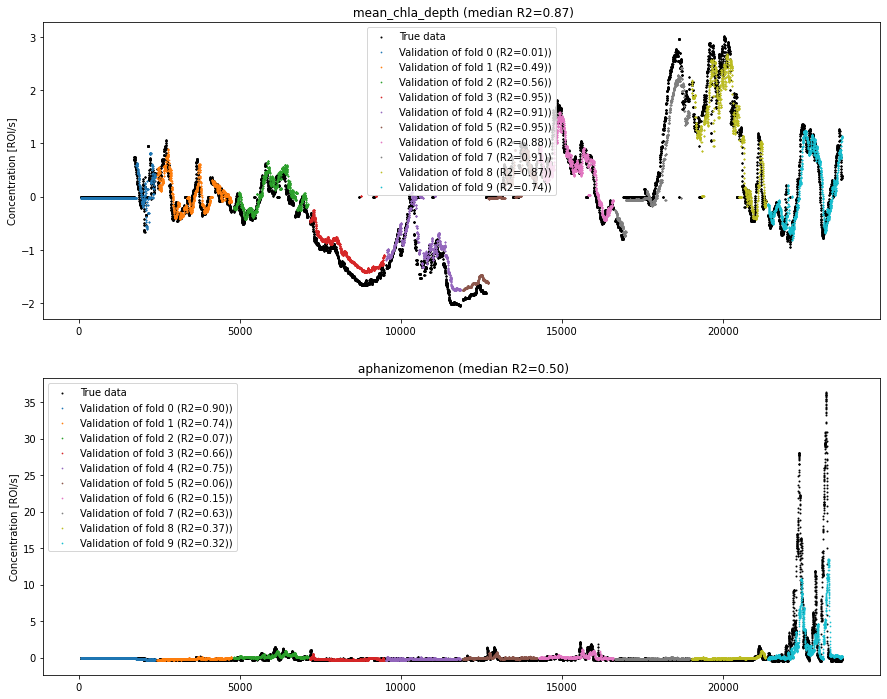

In [530]:
nice_plot(res)

In [534]:
#compare the models:
run_names =  ['run-20220502_191721-2tdnutj7',
             'run-20220502_221715-34wgkdia',
             'run-20220502_232040-ixzvcctz',
             'run-20220502_233202-21q1icdy',
             'run-20220502_234357-345w6g6p',
             'run-20220502_235445-ovi0wq69',
             'run-20220503_001049-10j8mxbb',
             'run-20220503_002141-3calb0bt',
             'run-20220503_003146-eu4l8nd9',
             'run-20220503_004343-3t09sadw']
run_dirs = run_dirs = ["..\\spacetimeformer\\spacetimeformer\\data\\stf_LOG_DIR\\wandb\\" + run_name+"\\files\\config.yaml" 
           for run_name in run_names]
input_keys = list(df.keys().drop('Datetime'))
target_keys = ['mean_chla_depth','aphanizomenon','cluster_1','cluster_2','cluster_3','cluster_4','cluster_5','cluster_6',
               'cluster_7','cluster_8']
models = [Markov_lasso_model(target_keys, alpha = 0.05),lstm_loader(target_keys,run_dirs)]
models_name = ["Markov linear model","lstm"]


lag = 5


<span style='color:#0d0'>Markov linear model:  R2 mean_chla_depth:  0.82 (median)</span><span style='color:#080'> +/- 0.92</span><span style='color:#900'> worst case: -0.59</span>

<span style='color:#020'>                      R2 aphanizomenon:  0.14 (median)</span><span style='color:#090'> +/- 0.85</span><span style='color:#700'> worst case: -0.47</span>

<span style='color:#0b0'>                      R2 cluster_1:  0.70 (median)</span><span style='color:#0d0'> +/- 0.33</span><span style='color:#060'> worst case: 0.38</span>

<span style='color:#0a0'>                      R2 cluster_2:  0.63 (median)</span><span style='color:#0c0'> +/- 0.45</span><span style='color:#010'> worst case: 0.08</span>

<span style='color:#0c0'>                      R2 cluster_3:  0.78 (median)</span><span style='color:#0e0'> +/- 0.22</span><span style='color:#080'> worst case: 0.56</span>

<span style='color:#0c0'>                      R2 cluster_4:  0.75 (median)</span><span style='color:#080'> +/- 0.92</span><span style='color:#c00'> worst case: -0.78</span>

<span style='color:#080'>                      R2 cluster_5:  0.51 (median)</span><span style='color:#0c0'> +/- 0.44</span><span style='color:#030'> worst case: 0.22</span>

<span style='color:#090'>                      R2 cluster_6:  0.57 (median)</span><span style='color:#0b0'> +/- 0.53</span><span style='color:#010'> worst case: 0.12</span>

<span style='color:#080'>                      R2 cluster_7:  0.56 (median)</span><span style='color:#0a0'> +/- 0.69</span><span style='color:#100'> worst case: -0.12</span>

<span style='color:#040'>                      R2 cluster_8:  0.30 (median)</span><span style='color:#0b0'> +/- 0.58</span><span style='color:#400'> worst case: -0.28</span>

<span style='color:#060'>lstm:  R2 mean_chla_depth:  0.43 (median)</span><span style='color:#060'> +/- 1.22</span><span style='color:#f00'> worst case: -1.00</span>

<span style='color:#090'>       R2 aphanizomenon:  0.61 (median)</span><span style='color:#030'> +/- 1.53</span><span style='color:#f00'> worst case: -1.70</span>

<span style='color:#0b0'>       R2 cluster_1:  0.70 (median)</span><span style='color:#0c0'> +/- 0.48</span><span style='color:#030'> worst case: 0.25</span>

<span style='color:#0a0'>       R2 cluster_2:  0.67 (median)</span><span style='color:#0a0'> +/- 0.62</span><span style='color:#010'> worst case: 0.07</span>

<span style='color:#0d0'>       R2 cluster_3:  0.82 (median)</span><span style='color:#0c0'> +/- 0.39</span><span style='color:#040'> worst case: 0.31</span>

<span style='color:#0a0'>       R2 cluster_4:  0.67 (median)</span><span style='color:#030'> +/- 1.54</span><span style='color:#f00'> worst case: -1.79</span>

<span style='color:#0c0'>       R2 cluster_5:  0.77 (median)</span><span style='color:#070'> +/- 1.00</span><span style='color:#b00'> worst case: -0.73</span>

<span style='color:#0c0'>       R2 cluster_6:  0.75 (median)</span><span style='color:#050'> +/- 1.26</span><span style='color:#b00'> worst case: -0.75</span>

<span style='color:#0c0'>       R2 cluster_7:  0.77 (median)</span><span style='color:#040'> +/- 1.43</span><span style='color:#f00'> worst case: -1.10</span>

<span style='color:#060'>       R2 cluster_8:  0.43 (median)</span><span style='color:#050'> +/- 1.26</span><span style='color:#f00'> worst case: -0.94</span>

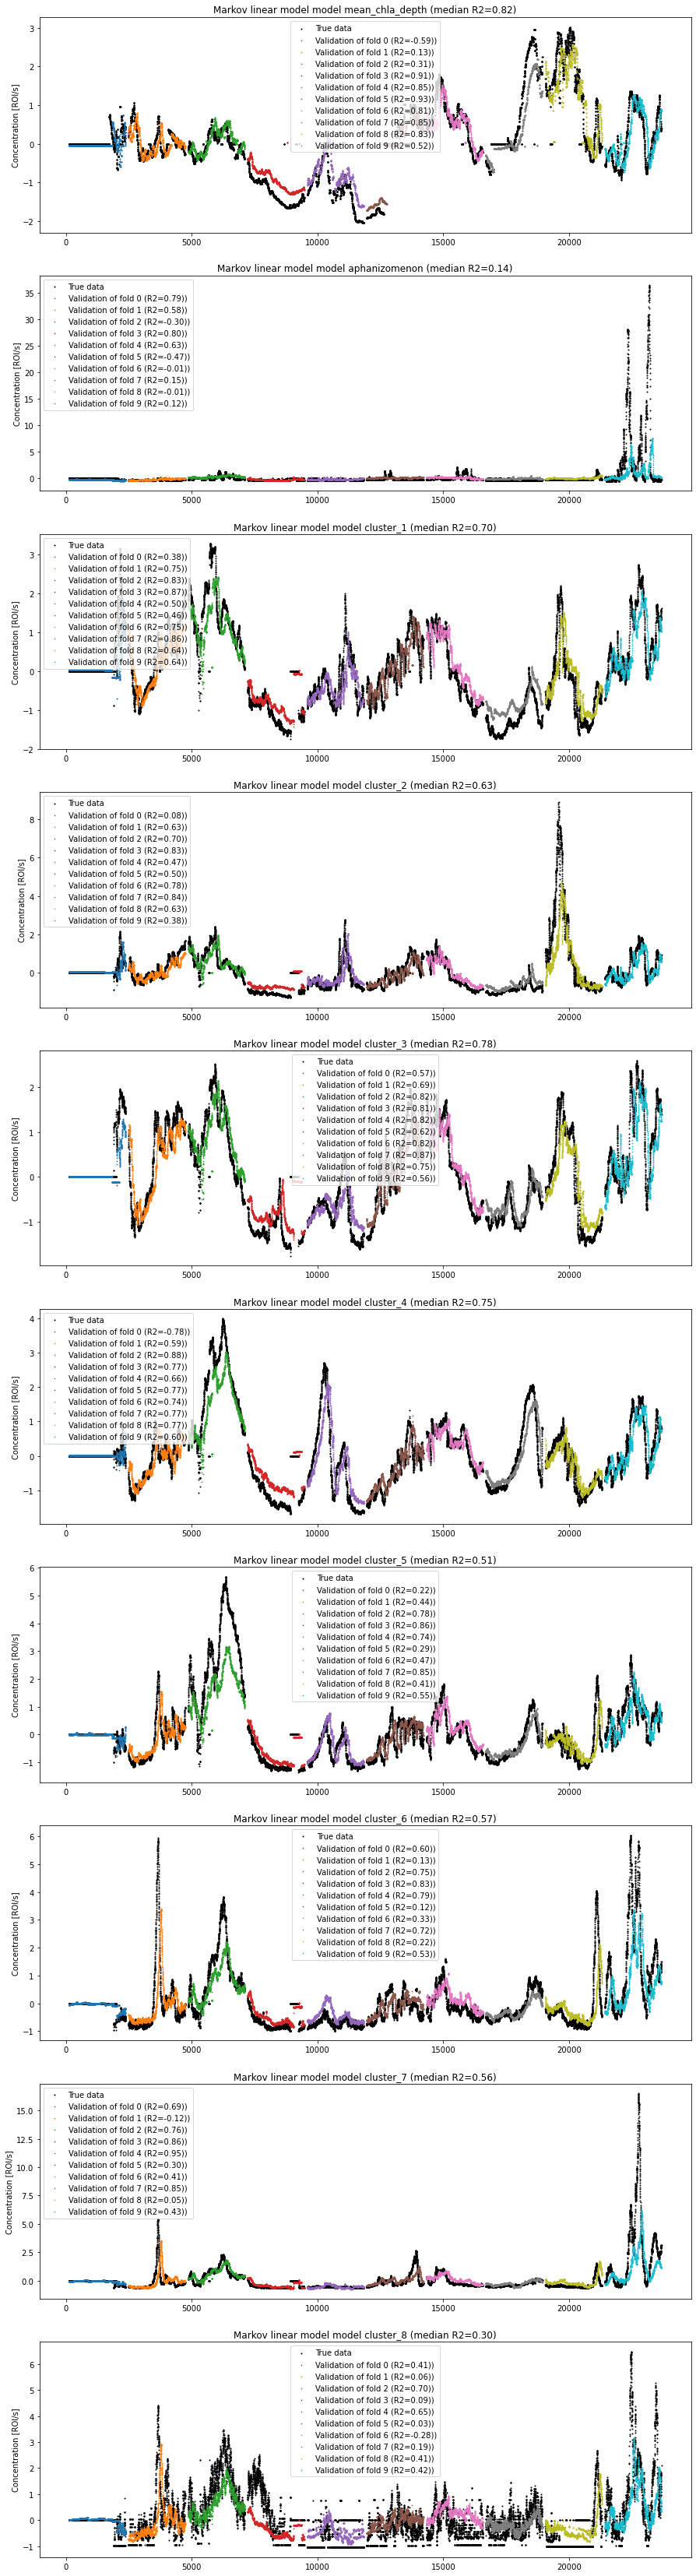

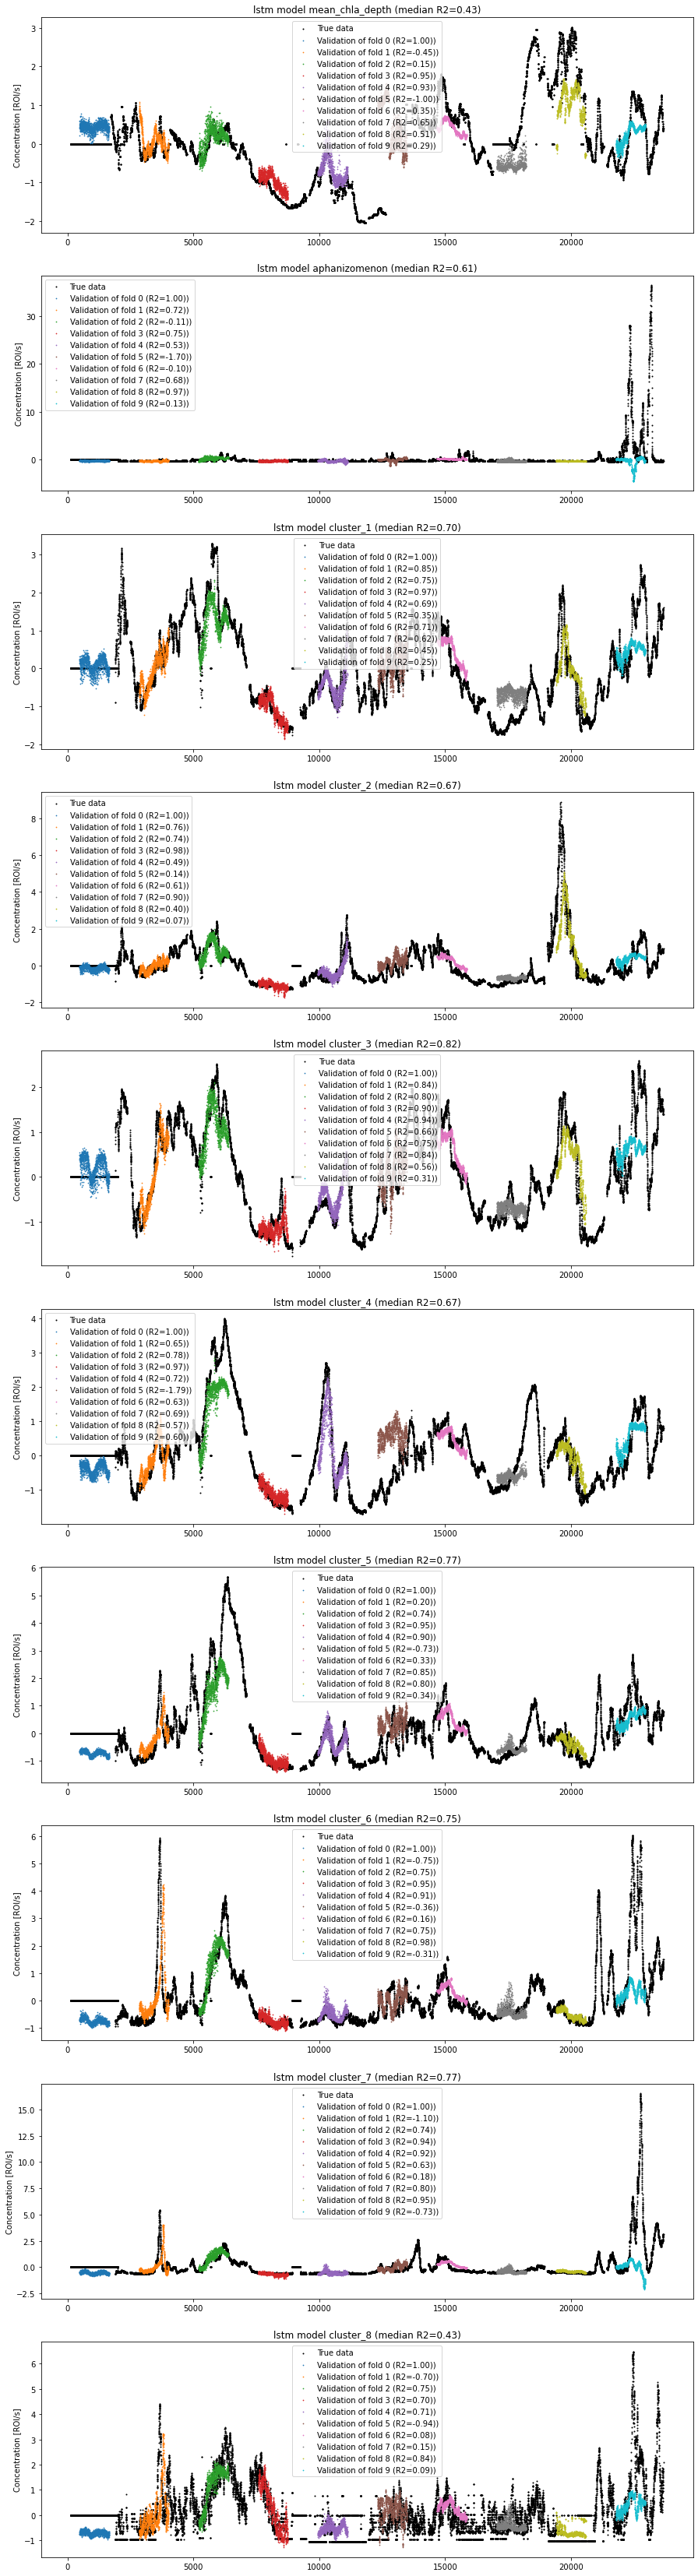

In [535]:

for model,name in zip(models,models_name):
        res = kfold(model,input_keys,target_keys,n_fold,lag)
        nice_plot(res,title = f"{name} model")
        plot_res(res,true_data=targets_tv,title=f"{name}:  ")

In [548]:
#plot the r2 vs lag graph for each model

#lags to fit a model to
maxlag = 30
lags = np.arange(1,maxlag+1)

#input keys
#in_keys = dftv.keys()
in_keys = df.keys()
#output keys 
target_keys= ['mean_chla_depth','aphanizomenon','cluster_1','cluster_2','cluster_3','cluster_4','cluster_5','cluster_6',
          'cluster_7','cluster_8']

#define the different models
models = []
models.append(CP_model(target_keys))
models.append(Markov_lasso_model(target_keys,alpha = 0.05,allow_neg = False))
models.append(lstm_loader(target_keys,run_dirs))
models_name = ['Copy-Paste','Lasso','LSTM']
#chose the number of folds
n_fold = 10
#chose some preprocessing:


res_model = []
for model in models:
    res_lag = []
    tar_lag = []
    for lag in lags:
        print(' '*100+f"lag {lag}/{lags[-1]}",end= '\r')
        res_lag.append(kfold(model,input_keys,target_keys,n_fold,lag))
        tar_lag.append(targets_tv)
    res_model.append(res_lag)

In [550]:
def R2_vs_lag(lags,res_model:list,tar_data:list,title="R2 vs lags",model_names = None):
    keys = res_model[0][0][0]['outkeys']
    fig,axs = plt.subplots(1,len(keys),figsize=(len(keys)*5,4))
    artists = np.empty((len(res_model),len(keys)),dtype=plt.Line2D)
    if len(tar_data)==1:
        tar_data = tar_data * len(res_model)
    for idx_model,(res_lag,tar_lag) in enumerate(zip(res_model,tar_data)):
        r2mean_lag = []
        for res,tar in zip(res_lag,tar_lag):
            r2mean_lag.append(np.nanmean([res_fold['s_val']['R2_cat'] for res_fold in res],axis=0))
        r2mean_lag = np.array(r2mean_lag)

        fig.suptitle(title)
        for idx,(ax,key) in enumerate(zip(axs,keys)):
            artists[idx_model,idx] = ax.plot(lags,r2mean_lag[:,idx])[0]
            ax.hlines(0,min(lags),max(lags),color='k',linestyle='dashed')
            ax.set_title(key)
            ax.set_xlabel("lag [day]")
            ax.set_ylabel("mean R2 over all folds")
            ax.set_ylim(max(-0.1,np.min(r2mean_lag[:,idx])-0.1),1)
    if model_names is not None:
        [ax.legend(artists[:,idx],model_names) for idx,ax in enumerate(axs)]
    plt.show()

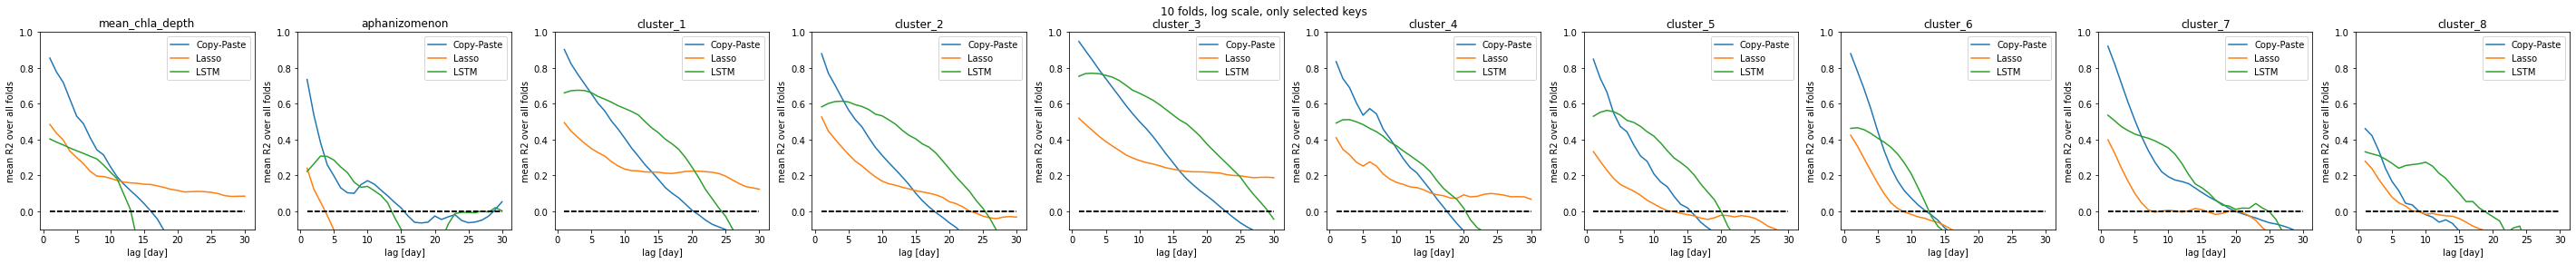

In [551]:
R2_vs_lag(lags,res_model,[tar_lag],title='10 folds, log scale, only selected keys',model_names = models_name)